<a href="https://colab.research.google.com/github/doohong91/reinforcement-learning-study/blob/main/ipynb/MountainCar_V0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
# libraries
import gym
import collections
from collections import namedtuple
import random

# pytorch library is used for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

# hyperparameters
learning_rate = 0.001
gamma = 0.99
buffer_limit = 20000        # size of replay buffer
batch_size = 64

In [117]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)    # double-ended queue
    
    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)

In [102]:
class DuelingQnet(nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_size=128):
        super(DuelingQnet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.fc_value = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc_adv = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.value = nn.Linear(hidden_layer_size, 1)
        self.adv = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        v = F.relu(self.fc_value(x))
        a = F.relu(self.fc_adv(x))
        v = self.value(v)
        a = self.adv(a)
        a_avg = torch.mean(a)
        q = v + a - a_avg
        return q

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else : 
            return out.argmax().item()  

In [103]:
class Qnet(nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_size=128):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc3 = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else : 
            return out.argmax().item()   

In [104]:
def train(q, q_target, memory, optimizer):
    for i in range(20):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1,a)

        # DQN
        # max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)

        # Double DQN
        argmax_Q = q(s_prime).max(1)[1].unsqueeze(1)
        max_q_prime = q_target(s_prime).gather(1, argmax_Q)

        target = r + gamma * max_q_prime * done_mask
        
        # MSE Loss
        # loss = F.mse_loss(q_a, target)

        # Smooth L1 Loss
        loss = F.smooth_l1_loss(q_a, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [138]:
# reward function reference: https://github.com/shivaverma/OpenAIGym/blob/master/mountain-car/MountainCar-v0.py

def get_reward(state):
    if state[0] >= 0.5:  # Car has reached the goal
        return 10
    return (2 * abs(state[1] + state[0]))**2

In [ ]:
env = gym.make('MountainCar-v0')

q = Qnet(env.observation_space.shape[0], env.action_space.n)
q_target = Qnet(env.observation_space.shape[0], env.action_space.n)
q_target.load_state_dict(q.state_dict())
memory = ReplayBuffer()

print_interval = 200
score = episode_score = 0.0
converged = 0.0
logs = []
optimizer = optim.Adam(q.parameters(), lr=learning_rate)

for n_epi in range(1, 10001):
    epsilon = max(0.01, 0.1 - 0.01*(n_epi/print_interval))
    s = env.reset()
    done = False
    
    while not done:
        a = q.sample_action(torch.from_numpy(s).float(), epsilon)
        s_prime, r, done, info = env.step(a)
        
        reward = get_reward(s_prime)
        if reward == 20:
            done_mask = 1.0
            converged += done_mask
        else:
            done_mask = 0.0

        memory.put((s, a, reward, s_prime, done_mask))
        s = s_prime

        if done: 
            break
        
        episode_score += r

    logs.append(episode_score)
    score += episode_score
    
    if memory.size() > 4000:
        train(q, q_target, memory, optimizer)

    if n_epi%print_interval==0 and n_epi!=0:
        q_target.load_state_dict(q.state_dict())
        print(f"n_episode: {n_epi}, avg_score: {score/print_interval:.1f}, converge_rate: {converged*100/print_interval:.2f}%, n_buffer: {memory.size()}, eps: {epsilon*100:.1f}%")
        score = converged = 0.0

    episode_score = 0.0
    
env.close()

n_episode: 200, avg_score: -190.9, converge_rate: 24.50%, n_buffer: 20000, eps: 9.0%
n_episode: 400, avg_score: -188.0, converge_rate: 33.00%, n_buffer: 20000, eps: 8.0%
n_episode: 600, avg_score: -194.2, converge_rate: 13.00%, n_buffer: 20000, eps: 7.0%
n_episode: 800, avg_score: -192.4, converge_rate: 18.00%, n_buffer: 20000, eps: 6.0%
n_episode: 1000, avg_score: -191.1, converge_rate: 21.50%, n_buffer: 20000, eps: 5.0%
n_episode: 1200, avg_score: -191.2, converge_rate: 21.00%, n_buffer: 20000, eps: 4.0%
n_episode: 1400, avg_score: -191.9, converge_rate: 20.50%, n_buffer: 20000, eps: 3.0%
n_episode: 1600, avg_score: -192.7, converge_rate: 17.00%, n_buffer: 20000, eps: 2.0%
n_episode: 1800, avg_score: -191.4, converge_rate: 19.50%, n_buffer: 20000, eps: 1.0%
n_episode: 2000, avg_score: -194.7, converge_rate: 15.00%, n_buffer: 20000, eps: 1.0%
n_episode: 2200, avg_score: -193.8, converge_rate: 17.50%, n_buffer: 20000, eps: 1.0%


Text(0, 0.5, 'Return')

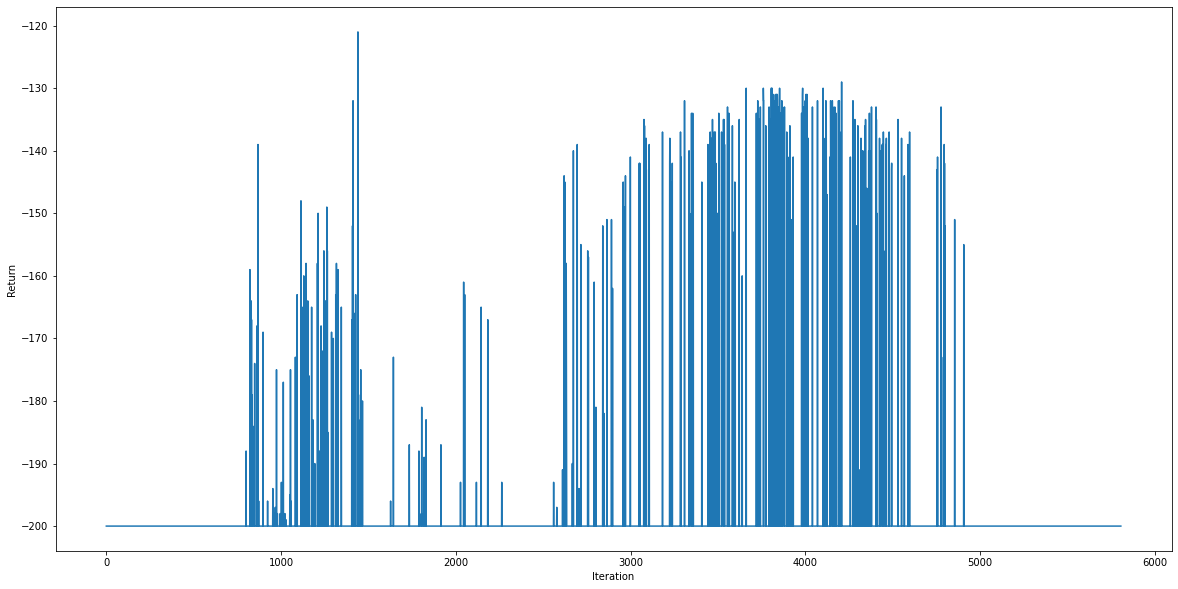

In [100]:
plt.figure(figsize=(20,10))
plt.plot(logs)
plt.xlabel('Iteration')
plt.ylabel('Return')

In [4]:
class PolicyNet(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_size=128):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_layer_size)
        self.fc2 = torch.nn.Linear(hidden_layer_size, output_size)
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, x):
        x = torch.from_numpy(x).float()
        return self.softmax(self.fc2(torch.nn.functional.relu(self.fc1(x))))

    def get_action_and_logp(self, x):
        action_prob = self.forward(x)
        m = torch.distributions.Categorical(action_prob)
        action = m.sample()
        logp = m.log_prob(action)
        return action.item(), logp

    def act(self, x):
        action, _ = self.get_action_and_logp(x)
        return action

class ValueNet(torch.nn.Module):
    def __init__(self, input_size, hidden_layer_size=128):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_layer_size)
        self.fc2 = torch.nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        x = torch.from_numpy(x).float()
        return self.fc2(torch.nn.functional.relu(self.fc1(x)))



In [7]:
def policyGradient(env, gamma=0.98, lr=0.01, num_traj=10, num_iter=200):
    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n
    Trajectory = namedtuple('Trajectory', 'states actions rewards dones logp')

    def collect_trajectory():
        state_list = []
        action_list = []
        reward_list = []
        dones_list = []
        logp_list = []
        state = env.reset()
        done = False
        steps = 0
        while not done:
            action, logp = policy.get_action_and_logp(state)
            newstate, reward, done, _ = env.step(action)
            state_list.append(state)
            action_list.append(action)
            reward_list.append(reward)
            dones_list.append(done)
            logp_list.append(logp)
            steps += 1
            state = newstate
        
        if sum(reward_list) >= -198:
            return Trajectory(states=state_list, actions=action_list, 
                              rewards=reward_list, logp=logp_list, dones=dones_list)
        return

    def calc_returns(rewards):
        dis_rewards = [gamma**i * r for i, r in enumerate(rewards)]
        return [sum(dis_rewards[i:]) for i in range(len(dis_rewards))]

    policy = PolicyNet(input_size, output_size)
    policy_optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    value = ValueNet(input_size)
    value_optimizer = torch.optim.Adam(value.parameters(), lr=lr)

    mean_return_list = []
    for it in range(num_iter):
        traj_list = []
        while len(traj_list) < num_traj:
            traj = collect_trajectory()
            if traj:
                traj_list.append(traj)

        returns = [calc_returns(traj.rewards) for traj in traj_list]

        #====================================#
        # policy gradient with base function #
        #====================================#
        policy_loss_terms = [-1. * traj.logp[j] * (returns[i][j] - value(traj.states[j]))
                            for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]

        #====================================#
        # policy gradient with reward-to-go  #
        #====================================#
        #policy_loss_terms = [-1. * traj.logp[j] * (torch.Tensor([returns[i][j]]))
        #                     for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]

        #====================================#
        # policy gradient                    #
        #====================================#
        # policy_loss_terms = [-1. * traj.logp[j] * (torch.Tensor([returns[i][0]]))
        #                      for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]

        policy_loss = 1. / num_traj * torch.cat(policy_loss_terms).sum()
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        value_loss_terms = [1. / len(traj.actions) * (value(traj.states[j]) - returns[i][j])**2.
                            for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]
        value_loss = 1. / num_traj * torch.cat(value_loss_terms).sum()
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

        mean_return = 1. / num_traj * sum([traj_returns[0] for traj_returns in returns])
        mean_return_list.append(mean_return)
        if it % 10 == 0:
            print('Iteration {}: Mean Return = {}'.format(it, mean_return))

    return policy, mean_return_list

In [8]:
env = gym.make('MountainCar-v0')
agent, mean_return_list = policyGradient(env, num_traj=5, num_iter=200, gamma=1.0)

KeyboardInterrupt: ignored

Text(0, 0.5, 'Average Return')

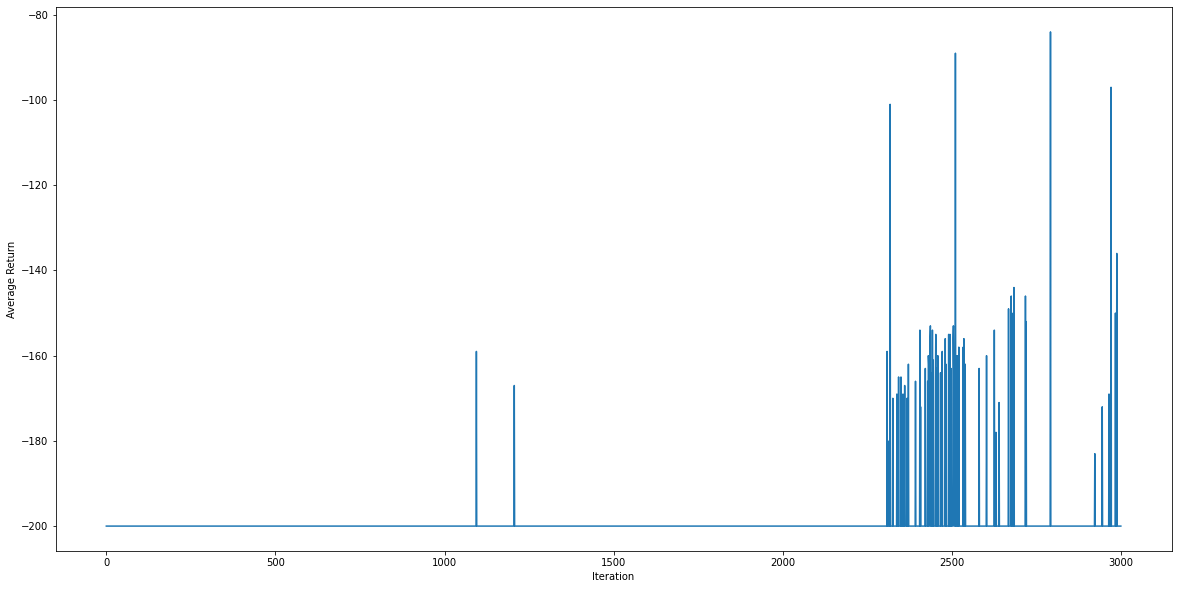

In [12]:
plt.figure(figsize=(20,10))
plt.plot(logs)
plt.xlabel('Iteration')
plt.ylabel('Average Return')